# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow.keras.utils as utils

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import sqlite3

## Declare parameters

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

IMAGE_SIZE = 512

API_KEY = "4INghUtThsIBWPTIcvfKyf0kNS6MtSXcC4R6mpNB"
BASE_URL = "https://api.nal.usda.gov/fdc/v1/"

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input class names

In [4]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

with open("condensed_category.txt", 'r') as file:
    file.readline()
    class_names = [line.strip().split("\t")[1] for line in file.readlines()]
    
class_names

['rice',
 "chicken-'n'-egg on rice",
 'beef curry',
 'sushi',
 'chicken rice',
 'fried rice',
 'toast',
 'croissant',
 'roll bread',
 'raisin bread',
 'hamburger',
 'pizza',
 'sandwiches',
 'spaghetti',
 'vegetable tempura',
 'sausage',
 'omelet',
 'stew',
 'fried fish',
 'grilled salmon',
 'sweet and sour pork',
 'tempura',
 'fried chicken',
 'steak',
 'egg sunny-side up',
 'roast chicken',
 'fried shrimp',
 'potato salad',
 'green salad',
 'pizza toast',
 'hot dog',
 'french fries',
 'mixed rice',
 'green curry',
 'paella',
 'pancake',
 'crape',
 'tiramisu',
 'waffle',
 'shortcake',
 'mushroom risotto',
 'french toast',
 'minestrone',
 'chicken nugget',
 'french bread',
 'bagel',
 'scone',
 'tortilla',
 'tacos',
 'nachos',
 'meat loaf',
 'scrambled egg',
 'lasagna',
 'Caesar salad',
 'oatmeal',
 'muffin',
 'popcorn',
 'doughnut',
 'apple pie',
 'lamb kebabs',
 'roast duck',
 'hot pot',
 'pork belly',
 'custard tart',
 'stir-fried mixed vegetables',
 'Pork with lemon',
 'Deep Fried Ch

# Input model

## Declare model architecture

Currently supports:
    - resnet_50
    - wide_resnet_50 (additional training required)
    - mobilenet_v2

In [5]:
MODEL_NAME = "resnet_50"

## Fetch model architecture

In [6]:
print("Fetching model architecture... ", end="")

if MODEL_NAME == "resnet_50":
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(class_names))    
    
    
elif MODEL_NAME == "wide_resnet_101":
    # fetch backbone model architecture
    backbone = torchvision.models.wide_resnet101_2(pretrained=False)

    # remove classification head
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 2048
    
    # encapsulate backbone within faster RCNN model
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

    
elif MODEL_NAME == "mobilenet_v2":
    # fetch backbone model architecture
    backbone = torchvision.models.mobilenet_v2(pretrained=False)

    # remove classification head
    backbone = backbone.features
    backbone.out_channels = 1280
    
    # encapsulate backbone within faster RCNN model
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

model = model.to(device)

print("done")

Fetching model architecture... done


## Load model weights

In [7]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "condensed_food_detection", MODEL_NAME, "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Predict on image

## Load image from url or given path

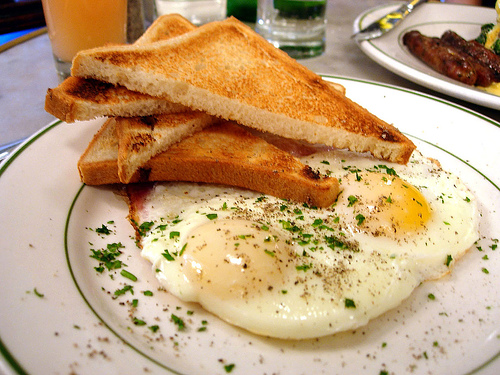

In [64]:
url = "https://media1.popsugar-assets.com/files/thumbor/xhwRJCRKQMcdn_ydpzBn1qPpZMo/fit-in/2048xorig/filters:format_auto-!!-:strip_icc-!!-/2014/07/16/939/n/1922729/fbeb92b7a978cd3a_paleo-bowl-main.jpg"
path = os.path.join(ROOT_DIR, "evaluation", "images", "example.jpg")

def loadURLImage(url):
    filename = url.split('/')[-1]
    img = utils.get_file(filename, url)
    img = Image.open(img)
    return img

def loadPathImage(path):
    img = Image.open(path)
    return img

img = loadPathImage(path)
#img = loadURLImage(url)
img

## Format image for model input

In [65]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))

        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return img

transform = CustomTransform(image_size=IMAGE_SIZE)

img = transform(img)
x = img.unsqueeze(0)

## Run inference on image

In [66]:
x = x.to(device)
model.eval()
    
with torch.no_grad():
    outputs = model(x)
    
outputs

[{'boxes': tensor([[142.1137, 157.5631, 482.1206, 351.6492],
          [ 59.4700,  12.8900, 425.4333, 203.0725],
          [  0.0000,  11.3846, 374.3970, 213.9240],
          [ 71.5314,  54.3479, 455.0676, 271.1923],
          [335.5468, 149.0141, 490.9091, 287.0627],
          [136.0675, 145.4338, 510.0446, 320.4044]], device='cuda:0'),
  'labels': tensor([24,  6, 18, 12, 24, 12], device='cuda:0'),
  'scores': tensor([0.9989, 0.9961, 0.2441, 0.1699, 0.0961, 0.0639], device='cuda:0')}]

## Extract results from model output (asking user when below threshold)

In [69]:
CONFIDENCE_THRESHOLD = 0.7
MIN_THRESHOLD = 0.5

def extractResults(output):
    boxes = []
    labels = []
    
    for i in range(len(output["labels"])):
        if(output["scores"][i] < MIN_THRESHOLD):
            break
            
        if(output["scores"][i] < CONFIDENCE_THRESHOLD):
            if(input("Is {0} present in this meal? (y/n): ".format(class_names[output["labels"][i]])) != 'y'):
                continue
        
        # extract bounding box
        boxes.append(output["boxes"][i])
        
        # extract label
        labels.append(output["labels"][i])
                       
    return boxes, labels

boxes, labels = extractResults(outputs[0])

## Draw predicted bounding boxes on image

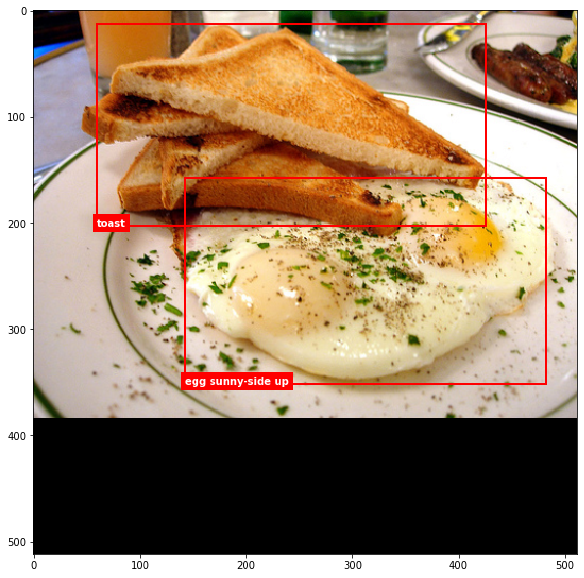

In [70]:
def drawResults(img, boxes, labels):
    fig, axis= plt.subplots(1, figsize=(10,10))
    
    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406

    img = np.transpose(img, (1,2,0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # draw results
    for i in range(len(labels)):
        # draw bounding box
        x1, y1, x2, y2 = boxes[i]
        box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        axis.add_patch(box)
        
        # draw class name
        axis.text(x1, y2, class_names[labels[i]], fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))
        
    plt.show()

drawResults(img.clone(), boxes, labels)

# Weight estimation

The next step is to estimate the weights for each of the foods present.

## Calculate surface areas

The first stage to estimating the portion size is to calculate the surface area for each of the foods detected. In order to do so we assume a standard plate diameter of 27cm and assume that the plate spans accross the whole image (bigger dimension). Since we don't have a database of food shapes we will also assume the captured food posses an eliptical shape.

In [74]:
PLATE_DIAMETER = 27 # cm

# estimate cms per pixel using standard plate diameter
cm_per_pixel = PLATE_DIAMETER / IMAGE_SIZE

surface_areas = []
for x1, y1, x2, y2 in boxes:    
    # assume food fills bounding box
    width = (x2 - x1) * cm_per_pixel
    height = (y2 - y1) * cm_per_pixel
    
    # estimate surface area using an oval shape (Pi * height/2 * width/2)
    surface_areas.append((np.pi * height/2 * width/2).item())

## Estimate volumes and weights

The next step is to estimate the volume of the food by using its given depth from a database of averages. In practice, this depth could be infered from a depth map. We then use the food's density, provided by http://foodinfo.us/Densities to infer its weight.

In [77]:
DATABASE_PATH = os.path.join(ROOT_DIR, "databases", "food.db")

# open nutritional database
connection = sqlite3.connect(DATABASE_PATH)
c = connection.cursor()

volumes = []
weights = []
energies = []
foods = []

i = 0
for lbl in labels:   
    # search food database for food information
    c.execute('SELECT * FROM food WHERE name = ?', (class_names[lbl],))
    _, class_name, energy, protein, fats, carbs, sugars, density, depth = c.fetchone()
    
    foods.append(class_name)
    
    # estimate volume using depth
    volumes.append(surface_areas[i] * depth)
    
    # estimate weight using density
    weights.append(volumes[i] * density)
    
    # infer energy using weight
    energies.append(weights[i] * energy / 100)
    
    i += 1
    
connection.close()

## Show overlay of estimated surface areas, volumes and weights

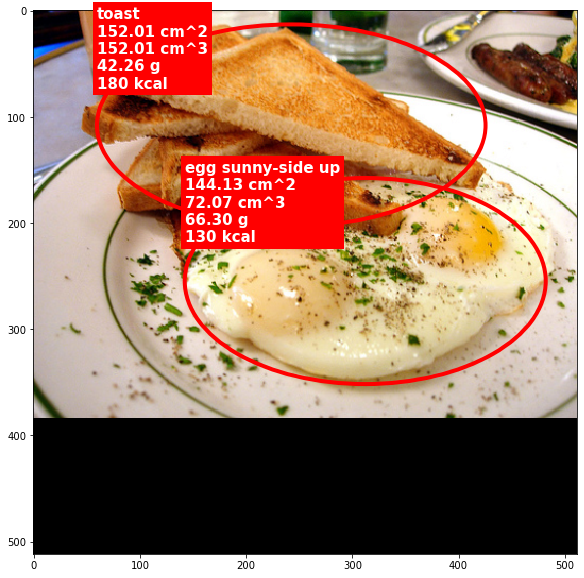

In [78]:
def showSizes(img, boxes):
    fig, axis= plt.subplots(1, figsize=(10,10))
    
    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406

    img = np.transpose(img, (1,2,0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # draw boudning box
    i = 0
    for x1, y1, x2, y2 in boxes:
        x = (x1+x2)/2
        y = (y1+y2)/2
        
        # draw area
        area = patches.Ellipse((x, y), x2-x1, y2-y1, linewidth=4, edgecolor='r', facecolor='none')
        axis.add_patch(area)
        
        # draw size information label
        lbl = "{0}\n{1:.2f} cm^2\n{2:.2f} cm^3\n{3:.2f} g\n{4} kcal".format(foods[i], surface_areas[i], volumes[i], weights[i], int(energies[i]))
        axis.text(x1, y1+60, lbl, fontdict=dict(color='w', weight='bold', size=15), bbox=dict(facecolor='r', edgecolor='none'))
        
        i += 1
        
    plt.show()

showSizes(img.clone(), boxes)

# Nutritional lookup

## Perform lookup of food items

Using the FoodData Central API we perform a lookup for each of the food items detected using the class as the search query.

In [79]:
food_ids = []

for class_name in foods:  
    # seach FoodData Central with class name as search term
    url = BASE_URL+"search"
    params = {
        'api_key': API_KEY,
        'generalSearchInput': class_name
    }
    data = requests.get(url=url, params=params).json()

    # take foodId from first result
    if len(data['foods']) > 0:
        food_ids.append(data['foods'][0]['fdcId'])
    else:
        print("Unable to find food with class {0}".format(class_name))
        
food_ids

[172074, 784589]

## Retrieve food information

We then request its nutritional contents and typical ingredients using the foodId retrieved.

In [80]:
food_info = []

for food_id in food_ids:
    # query FoodDataCentral for report
    url = BASE_URL+str(food_id)
    params = {
        'api_key': API_KEY
    }
    data = requests.get(url=url, params=params).json()
    food_info.append(data)

## Extract ingredients and compare with given allergies

In [86]:
ALLERGIES = []

ingredients = ""

# concatentate all ingredients together
for food in food_info:
    ingredients += food.get("ingredients", "")
    
# search for each allergy in ingredients
for allergy in ALLERGIES:
    if allergy.lower() in ingredients.lower():
        print("May contain {0}".format(allergy))

## Extract nutritional contents

In [82]:
nutrients = {}

# concatenate nutritional information of individual foods
i = 0
for food in food_info:
    for nutrient in food["foodNutrients"]:
        if nutrients.get(nutrient["nutrient"]["name"]):
            # append to existing nutient count
            nutrients[nutrient["nutrient"]["name"]]["amount"] += nutrient["amount"] * weights[i] / 100
            
        else:
            # create new nutrient value in dictionary
            nutrients[nutrient["nutrient"]["name"]] = {
                "amount": nutrient.get("amount", 0) * weights[i] / 100,
                "unitName": nutrient["nutrient"]["unitName"]
            }
            
    i += 1
        
nutrients
        
# display total nutitional contents
for nutrient in nutrients.keys():
    print("{0}: {1:.2f} {2}".format(nutrient, nutrients[nutrient]["amount"], nutrients[nutrient]["unitName"]))

Proximates: 0.00 g
Water: 64.43 g
Energy: 234.43 kcal
Protein: 5.80 g
Total lipid (fat): 1.48 g
Ash: 0.36 g
Carbohydrates: 0.00 g
Carbohydrate, by difference: 35.22 g
Fiber, total dietary: 3.72 g
Sugars, total including NLEA: 1.88 g
Sucrose: 0.11 g
Glucose (dextrose): 0.61 g
Fructose: 0.76 g
Lactose: 0.00 g
Maltose: 0.00 g
Galactose: 0.00 g
Minerals: 0.00 mg
Calcium, Ca: 55.21 mg
Iron, Fe: 1.99 mg
Potassium, K: 231.23 mg
Sodium, Na: 260.67 mg
Vitamins and Other Components: 0.00 g
Vitamin C, total ascorbic acid: 10.41 mg
Thiamin: 0.20 mg
Riboflavin: 0.14 mg
Niacin: 1.88 mg
Folate, total: 90.19 µg
Folate, food: 48.78 µg
Vitamin B-12: 0.00 µg
Vitamin A, IU: 1889.57 IU
Lipids: 0.00 g
Fatty acids, total saturated: 0.20 g
Fatty acids, total monounsaturated: 0.33 g
Fatty acids, total polyunsaturated: 0.59 g
Fatty acids, total trans: 0.00 g
Cholesterol: 0.00 mg
Alcohol, ethyl: 0.00 g
Caffeine: 0.00 mg
Theobromine: 0.00 mg
Magnesium, Mg: 24.93 mg
Phosphorus, P: 82.83 mg
Zinc, Zn: 0.85 mg
Copper